PROJECT 3 : **Medical Text Classification**

The goal of this project is to build a system for Medical Text Classification.
The input is a medical transcript and the output is one of four categories:
* Surgery (1)
* Medical Records (2)
* Internal Medicine (3)
* Other (4)

Since medical transcripts are variable-length texts, we need to convert them into fixed-length numerical vectors before applying classification algorithms.


Step 1 : Load datasets :

 Each file contain: text (medical transcript) and label (class number)

In [ ]:
from google.colab import files
uploaded_train=files.upload()
uploaded_validation=files.upload()
uploaded_test=files.upload()

Saving train.csv to train.csv


Saving valid.csv to valid.csv


Saving test.csv to test.csv


In [ ]:
import pandas as pd
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test  = pd.read_csv("test.csv")

print(train.head())


   label                                               text
0      2  2-D STUDY,1. Mild aortic stenosis, widely calc...
1      1  PREOPERATIVE DIAGNOSES: , Dysphagia and esopha...
2      2  CHIEF COMPLAINT:,  The patient comes for three...
3      1  PROCEDURE: , Bilateral L5, S1, S2, and S3 radi...
4      2  DISCHARGE DIAGNOSES:,1. Chronic obstructive pu...


Step 2: Data Preprocessing :

To improve model performance, several preprocessing steps were applied:

* Lowercasing: convert all words to lowercase.
* Removing punctuation and numbers using regular expressions.
* Stopword removal: removing frequent words with little semantic meaning (e.g., the, and, of).

In [ ]:
import re
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()
train["text"] = train["text"].apply(preprocess)
valid["text"] = valid["text"].apply(preprocess)
test["text"]  = test["text"].apply(preprocess)

Step 3: Vocabulary Construction :
* Vocabulary was built only from the training set.
* The top 10,000 most frequent words were selected.
* Each word was assigned a unique ID (starting from 1)


In [ ]:
from collections import Counter
all_tokens = " ".join(train["text"]).split()
counter = Counter(all_tokens)
TOP_K = 10000
most_common = counter.most_common(TOP_K)
vocab = {word: idx for idx, (word, freq) in enumerate(most_common, start=1)}


Save vocab file (format: word \ ID \ frequency) :

In [ ]:
with open("vocab.txt", "w", encoding="utf-8") as f:
    for idx, (word, freq) in enumerate(most_common, start=1):
        f.write(f"{word}\t{idx}\t{freq}\n")

Convert text to ID sequences (for saving train/valid/test) :

In [ ]:
def text_to_id_sequence(text, vocab):
    return " ".join(str(vocab[w]) for w in text.split() if w in vocab)

def write_id_file(df, out_path, vocab):
    with open(out_path, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            ids = text_to_id_sequence(row["text"], vocab)
            f.write(f"{ids}\t{row['label']}\n")

write_id_file(train, "train_ids.txt", vocab)
write_id_file(valid, "valid_ids.txt", vocab)
write_id_file(test, "test_ids.txt", vocab)

Step 4 : Text Vectorization :

Two main Bag-of-Words (BoW) representations were used:

1. Binary Bag-of-Words (BBoW)

* If a word appears in the text → 1

* If not → 0

* roduces a 10,000-dimensional binary vector.

2. Frequency Bag-of-Words (FBoW)

* Word count / Total number of words in the text

* Normalized so that the vector sums to 1.

In [ ]:
import numpy as np
def text_to_bbow(text, vocab):
    vec = np.zeros(max(vocab.values()) + 1)
    for word in set(text.split()):
        if word in vocab:
            vec[vocab[word]] = 1
    return vec

In [ ]:
def text_to_fbow(text, vocab):
    vec = np.zeros(max(vocab.values()) + 1)
    words = text.split()
    for word in words:
        if word in vocab:
            vec[vocab[word]] += 1
    if len(words) > 0:
        vec /= len(words)
    return vec

Step 5 : Build feature matrices :


In [ ]:
X_train_bbow = np.array([text_to_bbow(t, vocab) for t in train["text"]])
X_valid_bbow = np.array([text_to_bbow(t, vocab) for t in valid["text"]])
X_test_bbow  = np.array([text_to_bbow(t, vocab) for t in test["text"]])
X_train_fbow = np.array([text_to_fbow(t, vocab) for t in train["text"]])
X_valid_fbow = np.array([text_to_fbow(t, vocab) for t in valid["text"]])
X_test_fbow  = np.array([text_to_fbow(t, vocab) for t in test["text"]])

y_train, y_valid, y_test = train["label"], valid["label"], test["label"]


Step 8: Define models :

Four machine learning models were implemented:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

 Fix labels for XGBoost (must start at 0) :

(If labels are [1,2,3,4], shift them to [0,1,2,3])

In [ ]:
y_train = y_train - 1
y_valid = y_valid - 1
y_test  = y_test - 1

step 9 : evaluate with BBoW & FBOW :

The performance metric used was Macro F1-score, evaluated on:

* Training set

* Validation set

* Test set




In [ ]:
def evaluate(models, X_train, X_valid, X_test, y_train, y_valid, y_test):
    for name, model in models.items():
        print(f"\n=== {name} ===")
        model.fit(X_train, y_train)
        print("F1 (train):", f1_score(y_train, model.predict(X_train), average="macro"))
        print("F1 (valid):", f1_score(y_valid, model.predict(X_valid), average="macro"))
        print("F1 (test) :", f1_score(y_test,  model.predict(X_test),  average="macro"))


evaluate with BBoW :



In [ ]:
evaluate(models, X_train_bbow, X_valid_bbow, X_test_bbow, y_train, y_valid, y_test)


=== LogReg ===
F1 (train): 0.828009415610148
F1 (valid): 0.48763308260785765
F1 (test) : 0.5051608543869287

=== DecisionTree ===
F1 (train): 0.8206086617340784
F1 (valid): 0.45309550939599474
F1 (test) : 0.47640923211104447

=== RandomForest ===
F1 (train): 0.8273185059470866
F1 (valid): 0.2818059036255939
F1 (test) : 0.27586627957473353

=== XGBoost ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:07:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 (train): 0.82529987931102
F1 (valid): 0.5503417733886483
F1 (test) : 0.57612047581331


📌 Conclusion:

🔹 Logistic Regression

* Train F1 ≈ 0.82

* Valid/Test F1 ≈ 0.49–0.50

The model performs well on training but drops significantly on validation and test → clear overfitting (it memorized patterns from training but fails to generalize).

🔹 Decision Tree

* Train F1 ≈ 0.82

* Valid/Test F1 ≈ 0.45–0.47

Very similar to Logistic Regression but slightly worse on validation/test → also overfitting.

🔹 Random Forest

* Train F1 ≈ 0.82

* Valid/Test F1 ≈ 0.27–0.28

Performance on validation and test is much worse.
The BBoW representation introduces too much noise.
Overall, this configuration severely overfits.

🔹 XGBoost

* Train F1 ≈ 0.82

* Valid/Test F1 ≈ 0.55–0.57

Best performance among the four models on validation and test.
Still some gap between train and test, but much better generalization compared to others.


evaluate with FBOW :

In [ ]:
evaluate(models, X_train_bbow, X_valid_fbow, X_test_fbow, y_train, y_valid, y_test)


=== LogReg ===
F1 (train): 0.828009415610148
F1 (valid): 0.09562398703403566
F1 (test) : 0.08471760797342193

=== DecisionTree ===
F1 (train): 0.8206086617340784
F1 (valid): 0.090311986863711
F1 (test) : 0.07698815566835872

=== RandomForest ===
F1 (train): 0.8277925500920866
F1 (valid): 0.09562398703403566
F1 (test) : 0.08471760797342193

=== XGBoost ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:20:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 (train): 0.82529987931102
F1 (valid): 0.09562398703403566
F1 (test) : 0.08471760797342193


📌 Conclusion:

🔹 Logistic Regression

* Train F1 ≈ 0.83

* Valid/Test F1 ≈ 0.085–0.096

The model performs very well on training but drops drastically on validation and test → severe overfitting. The model memorized the training data but fails to generalize.

🔹 Decision Tree

* Train F1 ≈ 0.82

* Valid/Test F1 ≈ 0.077–0.090

Slightly worse than Logistic Regression on validation/test. Overfitting is clear, and single trees are unstable with this dataset.

🔹 Random Forest

* Train F1 ≈ 0.83

* Valid/Test F1 ≈ 0.085–0.096

Almost identical to Logistic Regression, indicating that bagging didn’t help much → likely the features or class imbalance are limiting performance.

🔹 XGBoost

* Train F1 ≈ 0.83

* Valid/Test F1 ≈ 0.085–0.096

Slightly better training F1, but validation/test performance is essentially the same as Logistic Regression/Random Forest.

Step 10 : Hyperparameter Analysis:

To better understand model behavior, key hyperparameters were varied, and F1-scores were plotted for train/validation sets.

1. Logistic Regression :

   Hyperparameter→ C

   Small C → strong regularization → underfitting

   Large C → weak regularization → overfitting

Find best C (BBOW):

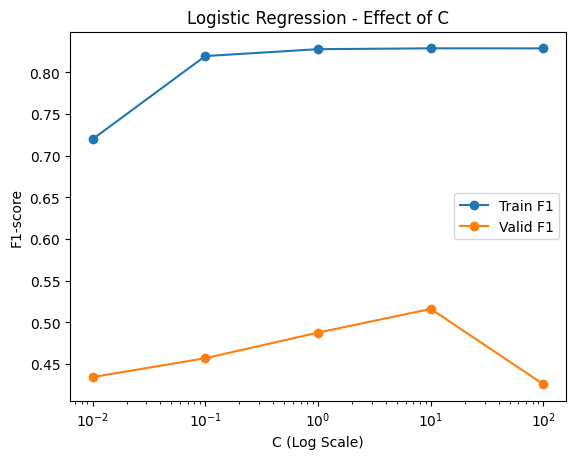

In [ ]:
import matplotlib.pyplot as plt
Cs = [0.01, 0.1, 1, 10, 100]
train_scores, valid_scores = [], []
for c in Cs:
    clf = LogisticRegression(C=c, max_iter=1000)
    clf.fit(X_train_bbow, y_train)
    train_scores.append(f1_score(y_train, clf.predict(X_train_bbow), average="macro"))
    valid_scores.append(f1_score(y_valid, clf.predict(X_valid_bbow), average="macro"))
plt.plot(Cs, train_scores, marker="o", label="Train F1")
plt.plot(Cs, valid_scores, marker="o", label="Valid F1")
plt.xscale("log")
plt.xlabel("C (Log Scale)")
plt.ylabel("F1-score")
plt.title("Logistic Regression - Effect of C")
plt.legend()
plt.show()

Logistic Regression with best C :
* Retrain model on Train + Valid
* Evaluate on test set



In [ ]:
best_C = 0.1
X_combined = np.vstack([X_train_bbow, X_valid_bbow])
y_combined = np.hstack([y_train, y_valid])
final_model = LogisticRegression(C=best_C, max_iter=1000)
final_model.fit(X_combined, y_combined)
test_pred = final_model.predict(X_test_bbow)
final_test_score = f1_score(y_test, test_pred, average="macro")
print("Final Test F1 with best C =", final_test_score)


Final Test F1 with best C = 0.4756345405466127


Find best C (FBOW):

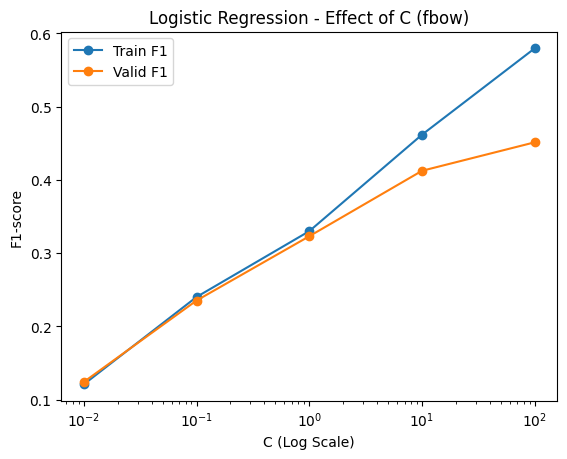

In [ ]:
Cs = [0.01, 0.1, 1, 10, 100]
train_scores, valid_scores = [], []
for c in Cs:
    clf = LogisticRegression(C=c, max_iter=1000)
    clf.fit(X_train_fbow, y_train)
    train_scores.append(f1_score(y_train, clf.predict(X_train_fbow), average="macro"))
    valid_scores.append(f1_score(y_valid, clf.predict(X_valid_fbow), average="macro"))
plt.plot(Cs, train_scores, marker="o", label="Train F1")
plt.plot(Cs, valid_scores, marker="o", label="Valid F1")
plt.xscale("log")
plt.xlabel("C (Log Scale)")
plt.ylabel("F1-score")
plt.title("Logistic Regression - Effect of C (fbow)")
plt.legend()
plt.show()

Logistic Regression with best C :
* Retrain model on Train + Valid
* Evaluate on test set



In [ ]:
best_C = 1
X_combined = np.vstack([X_train_fbow, X_valid_fbow])
y_combined = np.hstack([y_train, y_valid])
final_model = LogisticRegression(C=best_C, max_iter=1000)
final_model.fit(X_combined, y_combined)
test_pred = final_model.predict(X_test_fbow)
final_test_score = f1_score(y_test, test_pred, average="macro")
print("Final Test F1 with best C =", final_test_score)


Final Test F1 with best C = 0.3393571751392533


2. Decision Tree :

   Hyperparameter → max_depth

   Small depth → underfitting

   Large depth → overfitting

Find best depth (BBOW) :

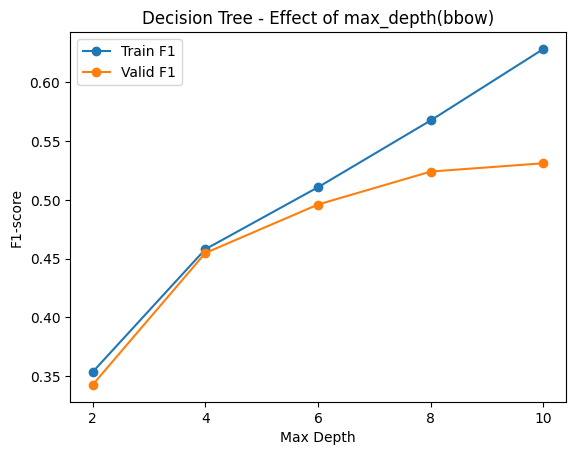

In [ ]:
depths = [2, 4, 6, 8, 10]
train_scores, valid_scores= [], []
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train_bbow, y_train)
    train_scores.append(f1_score(y_train, clf.predict(X_train_bbow), average="macro"))
    valid_scores.append(f1_score(y_valid, clf.predict(X_valid_bbow), average="macro"))
plt.plot([str(d) for d in depths], train_scores, marker="o", label="Train F1")
plt.plot([str(d) for d in depths], valid_scores, marker="o", label="Valid F1")
plt.xlabel("Max Depth")
plt.ylabel("F1-score")
plt.title("Decision Tree - Effect of max_depth(bbow)")
plt.legend()
plt.show()

 Decision tree with best depth :
* Retrain model on Train + Valid
* Evaluate on test set


In [ ]:
best_depth = 6
X_combined = np.vstack([X_train_bbow, X_valid_bbow])
y_combined = np.hstack([y_train, y_valid])
final_model = DecisionTreeClassifier(max_depth=best_depth)
final_model.fit(X_combined, y_combined)
test_pred = final_model.predict(X_test_bbow)
print("Final Test F1 with best max_depth =",
      f1_score(y_test, test_pred, average="macro"))

Final Test F1 with best max_depth = 0.4969953873332244


Find best depth (FBOW) :

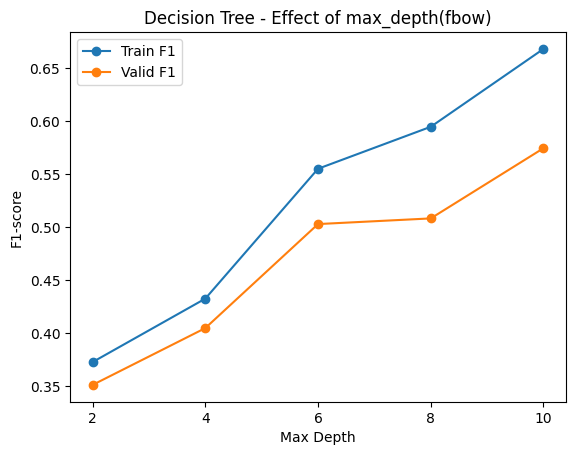

In [ ]:
depths = [2, 4, 6, 8, 10]
train_scores, valid_scores= [], []
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train_fbow, y_train)
    train_scores.append(f1_score(y_train, clf.predict(X_train_fbow), average="macro"))
    valid_scores.append(f1_score(y_valid, clf.predict(X_valid_fbow), average="macro"))
plt.plot([str(d) for d in depths], train_scores, marker="o", label="Train F1")
plt.plot([str(d) for d in depths], valid_scores, marker="o", label="Valid F1")
plt.xlabel("Max Depth")
plt.ylabel("F1-score")
plt.title("Decision Tree - Effect of max_depth(fbow)")
plt.legend()
plt.show()

 Decision tree with best depth :
* Retrain model on Train + Valid
* Evaluate on test set


In [ ]:
best_depth = 6

X_combined = np.vstack([X_train_fbow, X_valid_fbow])
y_combined = np.hstack([y_train, y_valid])

final_model = DecisionTreeClassifier(max_depth=best_depth)
final_model.fit(X_combined, y_combined)

test_pred = final_model.predict(X_test_fbow)
print("Final Test F1 with best max_depth =",
      f1_score(y_test, test_pred, average="macro"))


Final Test F1 with best max_depth = 0.5250952130313992


3. Random Forest :

   Hyperparameter → n_estimators
   
    Few trees → weak model

    Many trees → better performance but higher training time

Find best n (BBOW):

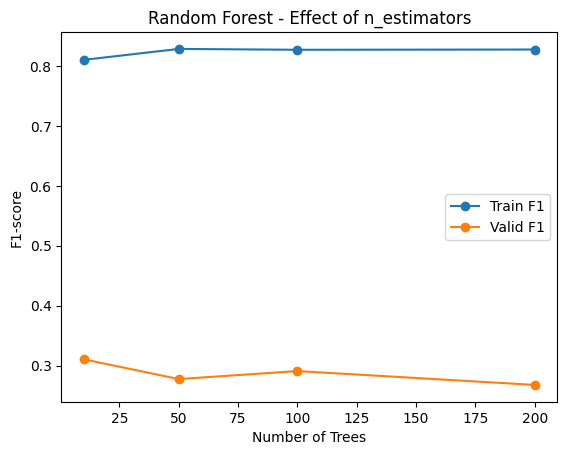

In [ ]:
n_estimators = [10, 50, 100, 200]
train_scores, valid_scores = [], []
for n in n_estimators:
    clf = RandomForestClassifier(n_estimators=n)
    clf.fit(X_train_bbow, y_train)
    train_scores.append(f1_score(y_train, clf.predict(X_train_bbow), average="macro"))
    valid_scores.append(f1_score(y_valid, clf.predict(X_valid_bbow), average="macro"))

plt.plot(n_estimators, train_scores, marker="o", label="Train F1")
plt.plot(n_estimators, valid_scores, marker="o", label="Valid F1")
plt.xlabel("Number of Trees")
plt.ylabel("F1-score")
plt.title("Random Forest - Effect of n_estimators(bbow)")
plt.legend()
plt.show()

 Random Forest with best n :
* Retrain model on Train + Valid
* Evaluate on test set

In [ ]:
best_n = 100
X_combined = np.vstack([X_train_bbow, X_valid_bbow])
y_combined = np.hstack([y_train, y_valid])
final_model = RandomForestClassifier(n_estimators=best_n)
final_model.fit(X_combined, y_combined)
test_pred = final_model.predict(X_test_bbow)
print("Final Test F1 with best n_estimators =",
      f1_score(y_test, test_pred, average="macro"))

Final Test F1 with best n_estimators = 0.25056945672128916


Find best n (FBOW):

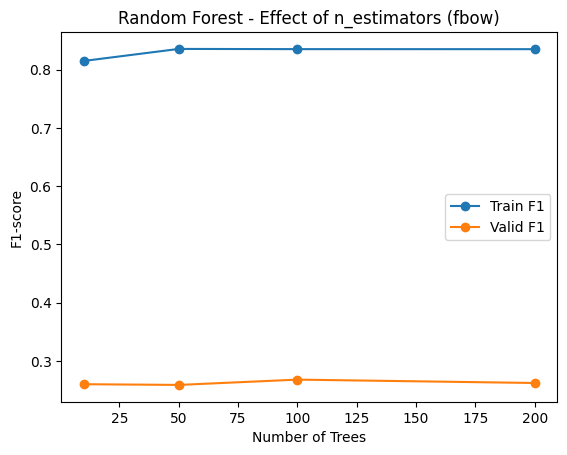

In [ ]:
n_estimators = [10, 50, 100, 200]
train_scores, valid_scores = [], []
for n in n_estimators:
    clf = RandomForestClassifier(n_estimators=n)
    clf.fit(X_train_fbow, y_train)
    train_scores.append(f1_score(y_train, clf.predict(X_train_fbow), average="macro"))
    valid_scores.append(f1_score(y_valid, clf.predict(X_valid_fbow), average="macro"))

plt.plot(n_estimators, train_scores, marker="o", label="Train F1")
plt.plot(n_estimators, valid_scores, marker="o", label="Valid F1")
plt.xlabel("Number of Trees")
plt.ylabel("F1-score")
plt.title("Random Forest - Effect of n_estimators (fbow)")
plt.legend()
plt.show()

 Random Forest with best n :
* Retrain model on Train + Valid
* Evaluate on test set

In [49]:
best_n = 100
X_combined = np.vstack([X_train_fbow, X_valid_fbow])
y_combined = np.hstack([y_train, y_valid])
final_model = RandomForestClassifier(n_estimators=best_n)
final_model.fit(X_combined, y_combined)
test_pred = final_model.predict(X_test_fbow)
print("Final Test F1 with best n_estimators =",
      f1_score(y_test, test_pred, average="macro"))

Final Test F1 with best n_estimators = 0.24462525170661442


4. XGBoost:

    Hyperparameter → learning_rate

    Too high → unstable training

    Too low → slow but stable learning

Find best eta (BBOW) :

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:43:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:44:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


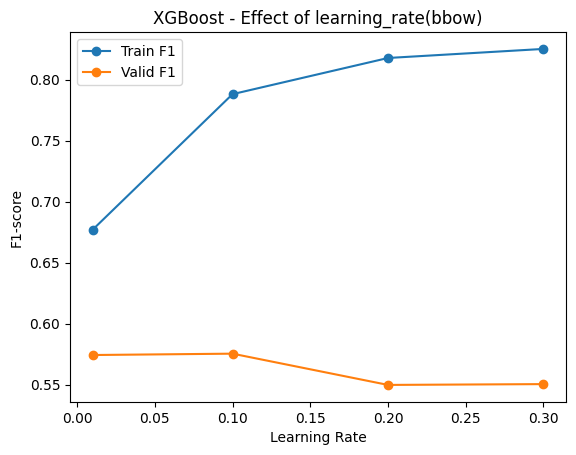

In [ ]:
etas = [0.01, 0.1, 0.2, 0.3]
train_scores, valid_scores = [], []
for eta in etas:
    clf = XGBClassifier(learning_rate=eta, use_label_encoder=False, eval_metric="mlogloss")
    clf.fit(X_train_bbow, y_train)
    train_scores.append(f1_score(y_train, clf.predict(X_train_bbow), average="macro"))
    valid_scores.append(f1_score(y_valid, clf.predict(X_valid_bbow), average="macro"))

plt.plot(etas, train_scores, marker="o", label="Train F1")
plt.plot(etas, valid_scores, marker="o", label="Valid F1")
plt.xlabel("Learning Rate")
plt.ylabel("F1-score")
plt.title("XGBoost - Effect of learning_rate(bbow)")
plt.legend()
plt.show()

  XGboost with best eta :
* Retrain model on Train + Valid
* Evaluate on test set

In [ ]:
best_eta = 0.1
X_combined = np.vstack([X_train_bbow, X_valid_bbow])
y_combined = np.hstack([y_train, y_valid])
final_model = XGBClassifier(learning_rate=best_eta,
                            use_label_encoder=False, eval_metric="mlogloss")
final_model.fit(X_combined, y_combined)
test_pred = final_model.predict(X_test_bbow)
print("Final Test F1 with best learning_rate =",
      f1_score(y_test, test_pred, average="macro"))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:48:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Test F1 with best learning_rate = 0.5867710596319407


Find best eta (FBOW) :

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:49:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:53:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:57:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


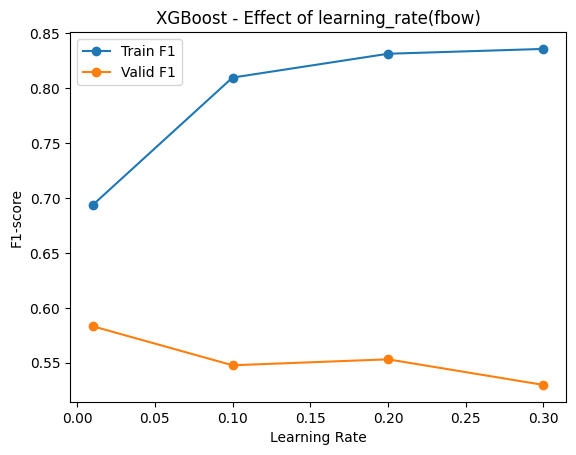

In [ ]:
etas = [0.01, 0.1, 0.2, 0.3]
train_scores, valid_scores = [], []
for eta in etas:
    clf = XGBClassifier(learning_rate=eta, use_label_encoder=False, eval_metric="mlogloss")
    clf.fit(X_train_fbow, y_train)
    train_scores.append(f1_score(y_train, clf.predict(X_train_fbow), average="macro"))
    valid_scores.append(f1_score(y_valid, clf.predict(X_valid_fbow), average="macro"))

plt.plot(etas, train_scores, marker="o", label="Train F1")
plt.plot(etas, valid_scores, marker="o", label="Valid F1")
plt.xlabel("Learning Rate")
plt.ylabel("F1-score")
plt.title("XGBoost - Effect of learning_rate(fbow)")
plt.legend()
plt.show()

  XGboost with best eta :
* Retrain model on Train + Valid
* Evaluate on test set

In [48]:
best_eta = 0.1
X_combined = np.vstack([X_train_fbow, X_valid_fbow])
y_combined = np.hstack([y_train, y_valid])
final_model = XGBClassifier(learning_rate=best_eta,
                            use_label_encoder=False, eval_metric="mlogloss")
final_model.fit(X_combined, y_combined)
test_pred = final_model.predict(X_test_fbow)
print("Final Test F1 with best learning_rate =",
      f1_score(y_test, test_pred, average="macro"))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:03:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Test F1 with best learning_rate = 0.6078407069583086


📌 Final conclusion:

 The optimal configuration for this Project is XGBoost with the specified hyperparameter (eta=0.1) using FBOW, providing a balanced trade-off between learning from training data and generalizing to unseen data.